# Introduction

This project consists of four categories:
1. Initial EDA
2. PCA
3. Linear Regression Model
4. Machine Learning Model

A. Supplementary Logistical Regression Model



# EDA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import geopandas as gpd
from pathlib import Path
import pathlib
import os
import requests, zipfile, io
import plotly

import warnings
warnings.filterwarnings('ignore')

Acknowledgement: Much of this code was helped made from my homework responses to AQI project from Data200 fall 2021. I give credit to the course staff for guiding me in many of these EDA ideas through the problem statements. Any code not provided in class was written by me

In [82]:
#works on linux machines!!
epa_data = {}
for root,dirs, files in os.walk(".",topdown=True):
    for name in files:
        if name[-4:] == ".csv":
            path = os.path.join(root, name)
            data = pd.read_csv(path)
            print(path)
            if "./AQI_Data/" in root:
                pattern = r"./AQI_Data/(\w+)/\w+.csv"
                ls_match = re.findall(pattern,str(path))
                if "/.ipynb" not in root:
                    print(ls_match)
                    name = ls_match[0]
                    epa_data[name] = data
            else:
                epa_data[name[:-4]] = data

KeyboardInterrupt: 

In [2]:
#works for windows!!
epa_data = {}
for root,dirs, files in os.walk(".",topdown=True):
    root_old = root
    p = pathlib.Path(root_old)
    root = p.as_posix()
#     print('root: '+root)
    for name in files:
#         print('name: '+name)
        if name[-4:] == ".csv":
            path = os.path.join(root_old, name)
            data = pd.read_csv(path)
#             print('path: '+path)
            if ".\\AQI_Data\\" in root_old:
                pattern = r".\\AQI_Data\\(\w+)\\\w+.csv"
                ls_match = re.findall(pattern,str(path))
                if "/.ipynb" not in root:
                    print(ls_match)
                    name = ls_match[0]
                    epa_data[name] = data
            else:
                epa_data[name[:-4]] = data

['annual_county_aqi']
['aqs_sites']
['daily_co']
['daily_county_aqi']
['daily_no2']
['daily_ozone']
['daily_so2']
['daily_temp']
['daily_wind']
['daily_wind']
['previous_data']


In [ ]:
#epa_data.keys()#check keys are correct

In [3]:
#add month and day to daily_county_aqi; df daily_county changes the object in the epa_data dictionary
daily_county = epa_data.get('daily_county_aqi')
daily_county['Month'] = pd.to_datetime(daily_county['Date']).dt.month
daily_county['Day'] = pd.to_datetime(daily_county['Date']).dt.day


daily_county.head()

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting,Month,Day
0,Alabama,Baldwin,1,3,2020-01-01,48,Good,PM2.5,01-003-0010,1,1,1
1,Alabama,Baldwin,1,3,2020-01-04,13,Good,PM2.5,01-003-0010,1,1,4
2,Alabama,Baldwin,1,3,2020-01-07,14,Good,PM2.5,01-003-0010,1,1,7
3,Alabama,Baldwin,1,3,2020-01-10,39,Good,PM2.5,01-003-0010,1,1,10
4,Alabama,Baldwin,1,3,2020-01-13,29,Good,PM2.5,01-003-0010,1,1,13


In [4]:
epa_data_CA = {}
keep_out = ['annual_county_aqi','aqs_sites','us_air_quality_measures','us_greenhouse_gas_emission_direct_emitter_gas_type',\
            'us_greenhouse_gas_emissions_direct_emitter_facilities','daily_global_weather_2020','2021','epa_filenames','Traffic_Volumes_AADT']
for table in list(epa_data):
    if table in keep_out:
        continue
    elif 'State Name' not in epa_data[table].keys():
        print(table)
        print(epa_data[table].head())
    else:
        epa_data_CA[table] = epa_data[table][epa_data[table]["State Name"] == 'California']

# epa_data_CA.get('daily_county_aqi').head()

2020
   AE000041196  20200101  TMIN  168 Unnamed: 4 Unnamed: 5  S  Unnamed: 7
0  AE000041196  20200101  PRCP    0          D        NaN  S         NaN
1  AE000041196  20200101  TAVG  211          H        NaN  S         NaN
2  AEM00041194  20200101  PRCP    0        NaN        NaN  S         NaN
3  AEM00041194  20200101  TAVG  217          H        NaN  S         NaN
4  AEM00041217  20200101  TAVG  205          H        NaN  S         NaN
ca_whole
  County Name  Date Local  AQI                        Category   Latitude  \
0      Fresno  2020-01-01  130  Unhealthy for Sensitive Groups  36.710833   
1      Fresno  2020-01-02  102  Unhealthy for Sensitive Groups  36.785380   
2      Fresno  2020-01-03   88                        Moderate  36.785380   
3      Fresno  2020-01-04   66                        Moderate  36.726390   
4      Fresno  2020-01-05   55                        Moderate  36.785380   

   Longitude  AQI_so2  Arithmetic Mean_so2  1st Max Value_so2  AQI_no2  ...  \
0 -119

In [5]:
# epa_data['annual_county_aqi'].keys()
epa_data['aqs_sites'].keys()

Index(['State Code', 'County Code', 'Site Number', 'Latitude', 'Longitude',
       'Datum', 'Elevation', 'Land Use', 'Location Setting',
       'Site Established Date', 'Site Closed Date', 'Met Site State Code',
       'Met Site County Code', 'Met Site Site Number', 'Met Site Type',
       'Met Site Distance', 'Met Site Direction', 'GMT Offset',
       'Owning Agency', 'Local Site Name', 'Address', 'Zip Code', 'State Name',
       'County Name', 'City Name', 'CBSA Name', 'Tribe Name',
       'Extraction Date'],
      dtype='object')

In [6]:
cols = ['State Name', 'county Name', 'Month', 'Day', 'AQI', 'Category', 'Defining Site', 'Latitude', 'Longitude']
epa_data['aqs_sites']['a'] = epa_data['aqs_sites']['State Code'].astype(str).str.zfill(2)
epa_data['aqs_sites']['b'] = epa_data['aqs_sites']['County Code'].astype(str).str.zfill(3)
epa_data['aqs_sites']['c'] = epa_data['aqs_sites']['Site Number'].astype(str).str.zfill(4)
epa_data['aqs_sites']['Defining Site'] = epa_data['aqs_sites']['a'] + '-' + epa_data['aqs_sites']['b'] + '-' + epa_data['aqs_sites']['c']
epa_data_CA_merged = epa_data_CA['daily_county_aqi'].merge(epa_data['aqs_sites'], how='left', left_on='Defining Site', right_on='Defining Site', suffixes=('', '_y'))[cols]

epa_data_CA_merged

,State Name,county Name,Month,Day,AQI,Category,Defining Site,Latitude,Longitude
0,California,Alameda,1,1,53,Moderate,06-001-0009,37.743065,-122.169935
1,California,Alameda,1,2,43,Good,06-001-0013,37.864767,-122.302741
2,California,Alameda,1,3,74,Moderate,06-001-0013,37.864767,-122.302741
3,California,Alameda,1,4,45,Good,06-001-0007,37.687526,-121.784217
4,California,Alameda,1,5,33,Good,06-001-0007,37.687526,-121.784217
...,...,...,...,...,...,...,...,...,...
19220,California,Yolo,12,27,20,Good,06-113-0004,38.534450,-121.773400
19221,California,Yolo,12,28,33,Good,06-113-0004,38.534450,-121.773400
19222,California,Yolo,12,29,28,Good,06-113-0004,38.534450,-121.773400
19223,California,Yolo,12,30,39,Good,06-113-0004,38.534450,-121.773400


## Missing AQI Data

In [7]:
ca_annual_data = epa_data.get('annual_county_aqi')[epa_data.get('annual_county_aqi')['State'] == 'California']
ca_aqi_days = ca_annual_data['Days with AQI'].sort_values()
ca_aqi_days.head(20)

54    274
96    331
63    351
98    353
49    359
76    360
51    364
57    364
72    365
79    366
81    366
82    366
83    366
84    366
85    366
80    366
86    366
48    366
88    366
78    366
Name: Days with AQI, dtype: int64

In [8]:
county_to_missing_dates = {}

interested = ca_aqi_days[ca_aqi_days != 366]

for idx in interested.index:
    county = ca_annual_data.loc[idx]['County']
    evaluate = epa_data_CA['daily_county_aqi'][epa_data_CA['daily_county_aqi']['county Name'] == county]
    evaluate.set_index('Date',inplace=True)
    evaluate.index = pd.to_datetime(evaluate.index)
    dates = pd.date_range(start = '2020-01-01',end='2020-12-31').difference(evaluate.index).strftime('%Y-%m-%d')
    county_to_missing_dates[county] = dates

county_to_missing_dates

{'Del Norte': Index(['2020-01-15', '2020-01-16', '2020-01-17', '2020-01-18', '2020-01-20',
        '2020-01-21', '2020-01-23', '2020-03-14', '2020-03-15', '2020-04-22',
        '2020-04-23', '2020-04-25', '2020-04-26', '2020-04-28', '2020-04-29',
        '2020-05-01', '2020-05-02', '2020-05-04', '2020-05-05', '2020-05-07',
        '2020-05-08', '2020-05-10', '2020-05-11', '2020-05-13', '2020-05-14',
        '2020-05-16', '2020-05-17', '2020-05-19', '2020-05-20', '2020-05-22',
        '2020-05-23', '2020-05-25', '2020-05-26', '2020-05-28', '2020-05-29',
        '2020-05-31', '2020-06-01', '2020-06-02', '2020-06-03', '2020-06-04',
        '2020-06-05', '2020-06-06', '2020-06-07', '2020-06-08', '2020-06-09',
        '2020-06-10', '2020-06-11', '2020-06-12', '2020-06-13', '2020-06-14',
        '2020-06-15', '2020-06-16', '2020-06-17', '2020-06-18', '2020-06-19',
        '2020-06-20', '2020-06-21', '2020-06-22', '2020-06-23', '2020-06-24',
        '2020-06-25', '2020-06-26', '2020-06-27', '

Major missing dates in common were: February 29, 2020 (Count = 3), as well as July 1, 2020 through July 14, 2020.  Del Norte and Trinity counties had the most missing dates, perhaps because the wildfires occuring in those counties had some AQI values omitted.

## AQI over time

In [9]:
aqi_per_month = epa_data['daily_county_aqi'].groupby("Month").mean()["AQI"]
aqi_per_month_CA = epa_data_CA['daily_county_aqi'].groupby("Month").mean()["AQI"]
print("AQI per Month: \n{}\n".format(aqi_per_month))
print("AQI per Month California : \n{}".format(aqi_per_month_CA))

AQI per Month: 
Month
1     31.032050
2     32.258621
3     34.509181
4     37.287264
5     36.273464
6     40.533681
7     40.070404
8     41.252281
9     43.290611
10    35.285558
11    34.184020
12    34.990632
Name: AQI, dtype: float64

AQI per Month California : 
Month
1      46.346888
2      47.110236
3      40.114094
4      41.443462
5      49.538319
6      47.996146
7      56.069375
8      79.960220
9     107.020228
10     75.491763
11     52.070573
12     53.645516
Name: AQI, dtype: float64


In [10]:
aqi_per_month = aqi_per_month.rename('AQI_all')
aqi_per_month_CA = aqi_per_month_CA.rename('AQI_CA')

In [11]:
aqi_per_month_df = pd.concat([aqi_per_month,aqi_per_month_CA], axis=1)
aqi_per_month_df = aqi_per_month_df.reset_index()
aqi_per_month_df

,Month,AQI_all,AQI_CA
0,1,31.032050,46.346888
1,2,32.258621,47.110236
2,3,34.509181,40.114094
3,4,37.287264,41.443462
4,5,36.273464,49.538319
5,6,40.533681,47.996146
6,7,40.070404,56.069375
7,8,41.252281,79.960220
8,9,43.290611,107.020228
9,10,35.285558,75.491763


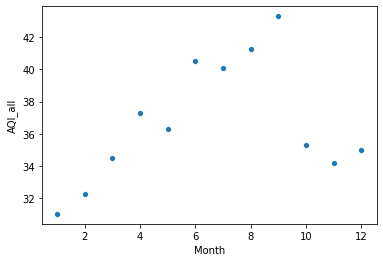

In [12]:
sns.scatterplot(x='Month',y='AQI_all',data=aqi_per_month_df)

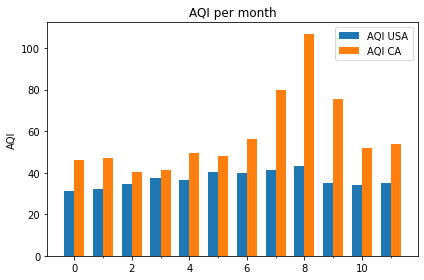

In [13]:
labels = ['1', '2', '3', '4', '5','6','7','8','9','10','11','12']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, aqi_per_month, width, label='AQI USA')
rects2 = ax.bar(x + width/2, aqi_per_month_CA, width, label='AQI CA')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('AQI')
ax.set_title('AQI per month')
ax.set_xticks(x, labels)
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

We can see that the average AQI per month in the state of california is on average higher than the average for all US states. This is probably because CA has more wildfires on average compared to the rest of the USA. 

In [14]:
epa_data['annual_county_aqi'].head()

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days SO2,Days PM2.5,Days PM10
0,Alabama,Baldwin,2020,269,250,19,0,0,0,0,74,49,36,0,0,198,0,71,0
1,Alabama,Clay,2020,108,99,9,0,0,0,0,86,49,26,0,0,0,0,108,0
2,Alabama,DeKalb,2020,364,350,14,0,0,0,0,90,45,36,0,0,331,0,33,0
3,Alabama,Elmore,2020,197,197,0,0,0,0,0,47,41,31,0,0,197,0,0,0
4,Alabama,Etowah,2020,278,260,18,0,0,0,0,92,46,34,0,0,204,0,74,0


## Visualization of AQI

In [22]:
import geopandas as gpd
try:
    import mapclassify
except ImportError:
    %pip install mapclassify

In [23]:
coords = epa_data_CA_merged[epa_data_CA_merged['Month']==9][['Longitude','Latitude','AQI']]
coords

,Longitude,Latitude,AQI
244,-121.903019,37.701222,70
245,-121.903019,37.701222,62
246,-122.302741,37.864767,95
247,-122.302741,37.864767,67
248,-122.031547,37.654456,129
...,...,...,...
19128,-121.773400,38.534450,69
19129,-121.773400,38.534450,69
19130,-121.773400,38.534450,75
19131,-121.773400,38.534450,111


In [24]:
gdf = gpd.GeoDataFrame(
    coords, 
    geometry=gpd.points_from_xy(coords.Longitude, coords.Latitude)
)

gdf

AttributeError: module 'geopandas' has no attribute 'points_from_xy'

Plotting latitude and Longitude points on California (no heat value). This is essentially the AQI measuring locations

In [25]:
states =['California']
usa = gpd.read_file("https://raw.githubusercontent.com/danhammer/envirods/main/data/gz_2010_us_040_00_20m.geojson")
state_gdf = usa[usa.NAME.isin(states)]
mkt_gdf = gdf
# fig, ax = plt.subplots(figsize=(15,10))
fig, ax = plt.subplots()
state_gdf.plot(
    ax=ax,
    color="lightgrey",
    edgecolor="white"
)
mkt_gdf.plot(ax=ax,column=gdf.AQI,cmap = 'inferno',scheme='Percentiles',legend=True);


NameError: name 'gdf' is not defined

The heatmap roughly looks like the outline of California, and the dark areas represent eastern California historically affected by wildfires, typically mountainous regions with lots of vegetation.

California counties shown on the right - San Bernardino, Los Angeles, Riverside - experienced much worse air quality with median AQI ranging from 80 to 95. On the left side of the plot, counties such as Del Norte and Trinity had very good air quality overall, with median . On the right compared to counties on the left such as Del Norte and Trinity, which had median AQI ranging from 28 to 32.

## we can also plot the danger levels by color

In [21]:
###make AQI values correspond with government color system
#look up custom color map
states =['California']
usa = gpd.read_file("https://raw.githubusercontent.com/danhammer/envirods/main/data/gz_2010_us_040_00_20m.geojson")
state_gdf = usa[usa.NAME.isin(states)]
mkt_gdf = gdf
# fig, ax = plt.subplots(figsize=(15,10))
fig, ax = plt.subplots()
state_gdf.plot(
    ax=ax,
    color="lightgrey",
    edgecolor="white"
)
# mkt_gdf.plot(ax=ax,column=gdf.AQI,cmap = 'inferno',scheme='Percentiles',legend=True);
from matplotlib import colors
#make a color map of fixed colors
cmap = colors.ListedColormap(['Green','Yellow','Orange','Red','Purple','Maroon'])
bounds = [0,50,100,150,200,300,2000]
norm = colors.BoundaryNorm(bounds,cmap.N)

mkt_gdf.plot(ax=ax,column=gdf.AQI,cmap = cmap,norm=norm,legend=True);


NameError: name 'gdf' is not defined

## Missing AQI Data for CA

# PCA

# Linear Regression Model

# Machine Learning Model

# Supplementary Analysis

## Logistic Regression Model